<h2><center>Challenge 6</center></h2>

Librerias

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

*Bueno (ADN intacto o mínimamente dañado): Células que tienen una cola pequeña o no visible. La mayor parte del ADN permanece dentro del núcleo, lo que sugiere que la célula tiene ADN intacto.

*Malo (ADN dañado): Células que exhiben una cola pronunciada que se extiende desde el núcleo, lo que indica que el ADN se ha fragmentado, lo cual es un signo de daño.

**La base de datos se separó manualmente**

Malo

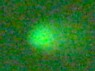

Bueno

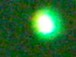

In [ ]:
# Rutas completas a las carpetas de datos
train_path = r'/content/drive/MyDrive/PUCP/2023-2/Reconocimiento de Patrones/Challenge 6/train'
test_path = r'/content/drive/MyDrive/PUCP/2023-2/Reconocimiento de Patrones/Challenge 6/test'

Código General

In [8]:
# Definir la arquitectura de la red neuronal convolucional (CNN)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Definir capas convolucionales
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Definir una capa de agrupación máxima
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Capa completamente conectada (la entrada se basa en el tamaño de la imagen y el número de canales después de las capas de agrupación)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)  # 2 clases: buena y mala
        # Función de activación ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        # Definir el paso hacia adelante a través de la red
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Aplanar la capa para la entrada al FC
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instanciar el modelo
model = SimpleCNN()

# Verificar si la GPU está disponible y mover el modelo a la GPU (ESTAMOS USANDO GPU del Colab)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la preprocesamiento de datos
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar las imágenes a 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar para cada canal
])



# Cargar los conjuntos de datos
train_data = datasets.ImageFolder(train_path, transform=transform)
test_data = datasets.ImageFolder(test_path, transform=transform)

# Crear cargadores de datos
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Bucle de entrenamiento
num_epochs = 10  # Definir el número de épocas
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, targets in train_loader:
        # Mover los datos al dispositivo (GPU o CPU)
        data, targets = data.to(device), targets.to(device)

        # Paso hacia adelante
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Paso hacia atrás y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumular la pérdida
        running_loss += loss.item() * data.size(0)
    # Calcular la pérdida promedio por época
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Bucle de prueba
model.eval()
correct = 0
total = 0

# Reinicializar el dispositivo por si se ejecuta esta parte del código independientemente
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Listas para guardar predicciones y etiquetas reales
all_preds = []
all_targets = []

# No calcular gradientes durante la prueba
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        # Guardar predicciones y verdaderas etiquetas
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calcular precisión
accuracy = 100 * correct / total
print(f'Precisión del modelo en imágenes de prueba: {accuracy:.2f}%')
# Calcular y mostrar métricas adicionales
print(classification_report(all_targets, all_preds, target_names=['bad', 'good']))
print(confusion_matrix(all_targets, all_preds))

Epoch 1/10, Loss: 2.6044
Epoch 2/10, Loss: 1.3788
Epoch 3/10, Loss: 0.6813
Epoch 4/10, Loss: 0.5870
Epoch 5/10, Loss: 0.4960
Epoch 6/10, Loss: 0.3919
Epoch 7/10, Loss: 0.2993
Epoch 8/10, Loss: 0.2528
Epoch 9/10, Loss: 0.2624
Epoch 10/10, Loss: 0.2952
Precisión del modelo en imágenes de prueba: 54.17%
              precision    recall  f1-score   support

         bad       0.47      0.90      0.62        10
        good       0.80      0.29      0.42        14

    accuracy                           0.54        24
   macro avg       0.64      0.59      0.52        24
weighted avg       0.66      0.54      0.50        24

[[ 9  1]
 [10  4]]


 Epochs en el Entrenamiento de Redes Neuronales

Los "epochs" en el entrenamiento de redes neuronales se refieren a las iteraciones completas a través del conjunto completo de datos de entrenamiento. Durante un epoch, la red pasa por cada ejemplo de entrenamiento una vez, ajustando sus pesos internos a medida que intenta aprender patrones y minimizar el error de predicción.

En la salida del entrenamiento mostrada, hay 10 epochs, lo que significa que el conjunto de datos completo se utilizó 10 veces para entrenar la red. Cada línea muestra el progreso después de completar un epoch, indicando que la pérdida, una medida de qué tan mal el modelo está prediciendo los datos de entrenamiento, disminuye generalmente, lo cual es indicativo de aprendizaje.

La disminución de la pérdida en los datos de entrenamiento no siempre implica un mejor desempeño en datos no vistos, por eso es crucial evaluar el modelo también en un conjunto de datos de prueba.

Matriz de Confusión

La matriz de confusión es una herramienta para evaluar el rendimiento de un modelo de clasificación. Para dos clases ('bad' y 'good'), la matriz de 2x2 muestra:

- Verdaderos positivos (VP): Instancias correctamente identificadas de una clase.
- Falsos negativos (FN): Instancias de una clase incorrectamente identificadas como la otra clase.
- Falsos positivos (FP): Instancias de la otra clase incorrectamente identificadas como pertenecientes a la clase en cuestión.
- Verdaderos negativos (VN): Instancias correctamente identificadas como no pertenecientes a la clase en cuestión.

Además de la matriz en sí, se derivan métricas de rendimiento como precisión, recall y F1-score, que proporcionan más detalles sobre el rendimiento del modelo en cada clase.


* **Verdaderos positivos (VP):** La celda superior izquierda
(9) muestra el número de veces que el modelo predijo correctamente la clase 'bad'.

* **Falsos negativos (FN):** La celda superior derecha (1) muestra el número de veces que el modelo predijo incorrectamente la clase 'good' cuando en realidad era 'bad'.

* **Falsos positivos (FP):** La celda inferior izquierda (10) muestra el número de veces que el modelo predijo la clase 'bad' cuando en realidad era 'good'.

* **Verdaderos negativos (VN):** La celda inferior derecha (4) muestra el número de veces que el modelo predijo correctamente la clase 'good'.